In [1]:
%pip install -qr seggpt/requirements.txt
%pip install -q autodistill roboflow supervision pycocotools palettable scipy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [13]:
%pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /var/tmp/pip-req-build-k4jxx584
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /var/tmp/pip-req-build-k4jxx584
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36588 sha256=aa0ebaf2013432aea0558156b51c2f5f662f534c8b2481c929e6ec5484ba25cd
  Stored in directory: /var/tmp/pip-ephem-wheel-cache-srjrfsyh/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment-anything
Note: you may need to restart the kernel to use updated packages.


In [8]:
!sh get_weights.sh

--2023-07-30 14:35:22--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 99.84.160.80, 99.84.160.108, 99.84.160.46, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|99.84.160.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   262MB/s    in 9.5s    

2023-07-30 14:35:32 (258 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]

--2023-07-30 14:35:32--  https://github.com/ChaoningZhang/MobileSAM/raw/master/weights/mobile_sam.pt
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ChaoningZhang/MobileSAM/master/weights/mobile_sam.pt [following]
--2023-07-30 14:35:32--  h

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from roboflow import login,Roboflow

login()
rf = Roboflow()

project = rf.workspace("roboflow-4rfmv").project("climbing-y56wy")
dataset = project.version(5).download("coco-segmentation")

You are already logged into Roboflow. To make a different login, run roboflow.login(force=True).
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Climbing-5 in coco-segmentation:: 100%|██████████| 51/51 [00:00<00:00, 2391.15it/s]


In [5]:
import supervision as sv

climbing_dataset = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/train",
    annotations_path=f"{dataset.location}/train/_annotations.coco.json",
    force_masks=True
)

In [6]:
from autodistill_seggpt.find_best_examples import find_best_examples
from autodistill_seggpt.seggpt import SegGPT
import json

use_cached = True

if not use_cached:
    best_examples = find_best_examples(
        climbing_dataset,
        SegGPT,
        num_examples=2,
        num_trials=5,
        max_test_imgs=10,
        which_metric="iou"
    )
    with open("best_examples.json","w") as f:
        json.dump(best_examples,f)
else:
    with open("best_examples.json","r") as f:
        best_examples = json.load(f)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [7]:
best_examples

{'0-climbing-holds': [],
 '1-climbing-holds': ['AF1QipMWEnam7zGb-HsVjoiH1ei4-z2aXbTf2uqHw1na-s812-k-no_jpeg.rf.4c832adeb2b0f76811d1310e20c0c2b8.jpg',
  'AF1QipPMtq9QM1wyPCpJgMDww2M7Gr9AxQla-3ru_uLD-w406-h541-k-no_jpeg.rf.1abf8bc38c3fd8c3ec97eddca63e8e7f.jpg'],
 '2-floor': ['AF1QipPYgER3vxVWDJYayeoJd_85oKw99NndlAMUNqop-s1354-k-no_jpeg.rf.092fd721f746762510b3d3121d4299b4.jpg',
  'AF1QipOzF-xFDKZhdLh-giQuhUmtsTrUFphSFO7uGjzf-w406-h271-k-no_jpeg.rf.80cf419f515fd20f2e3189d8a9613904.jpg'],
 '3-person': ['AF1QipM4mfSv7HgSN29oRV6OCo15Ce8Q6JBIhvGrs8MH-s1024_jpeg.rf.240399e52fadfd253b96967cd94e24e0.jpg',
  'AF1QipOjfvW1sr3mxkdmwGzbkvCzqIFvq6iESAQhyXUr-s1536_jpeg.rf.5b7e9f1a69ed8ea4edb225f9f4c50486.jpg']}

In [8]:
from autodistill_seggpt.seggpt import FewShotOntology,SegGPT
from autodistill.detection import CaptionOntology

climbing_ontology = CaptionOntology({
    "2-floor":"floor",
    "1-climbing-holds":"hold",
    "3-person":"climber",
})

few_shot_ontology = FewShotOntology.from_examples(
    ref_dataset=climbing_dataset,
    ontology=climbing_ontology,
    examples=best_examples
)

model = SegGPT(
    ontology=few_shot_ontology,
    refine_detections=True
)

In [9]:
from autodistill_seggpt.sam_refine import load_sam

sam_predictor = load_sam(sam_type="vit_h")

In [31]:
from random import choice
import os
import numpy as np
from PIL import Image

valid_dir = f"{dataset.location}/valid"
valid_images = [img for img in os.listdir(valid_dir) if not img.endswith(".json")]

demo_img_name = choice(valid_images)
demo_img = f"{valid_dir}/{demo_img_name}"

detections = model.predict(demo_img)

old_detections = detections

demo_image = Image.open(demo_img)
demo_image = np.array(demo_image)

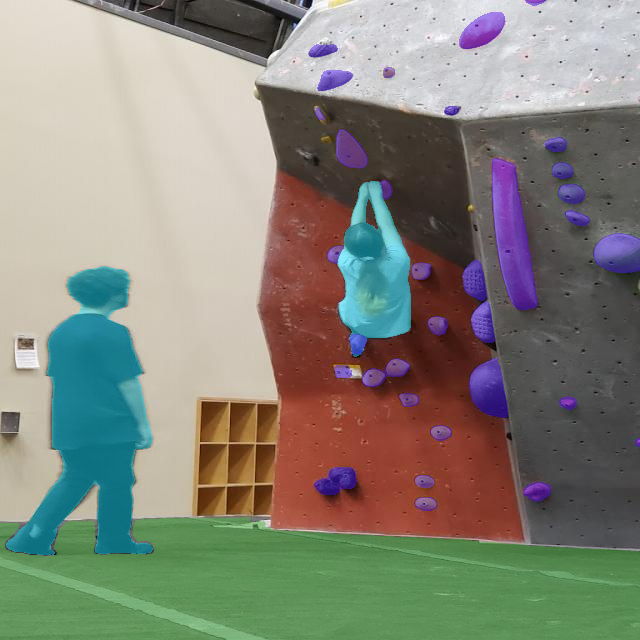

In [32]:
import cv2
from PIL import Image

annotator = sv.MaskAnnotator()
img = cv2.imread(demo_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

annotated_frame = annotator.annotate(
    scene=img.copy(),
    detections=detections
)
Image.fromarray(annotated_frame)